In [1]:
!pip install fastai

  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19189 sha256=4967ad559e137a8709fedbb8d8b53125a3af68fe5db6e4a2ad3e4c871a7084d5
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7f/26/a3/33f2079871e2bebb3f53a2b21c3ec64129b8efdd18a6263a52
Successfully built nvidia-ml-py3
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import numpy as np
import time
import torch

from pathlib import PosixPath
from pathlib import Path

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet18-5c106cde.pth


Learner(data=ImageDataBunch;

Train: LabelList (18000 items)
x: SegmentationItemList
Image (3, 256, 512),Image (3, 256, 512),Image (3, 256, 512),Image (3, 256, 512),Image (3, 256, 512)
y: SegmentationLabelList
ImageSegment (1, 256, 512),ImageSegment (1, 256, 512),ImageSegment (1, 256, 512),ImageSegment (1, 256, 512),ImageSegment (1, 256, 512)
Path: /home/ec2-user/SageMaker/preprocessed_data;

Valid: LabelList (2000 items)
x: SegmentationItemList
Image (3, 256, 512),Image (3, 256, 512),Image (3, 256, 512),Image (3, 256, 512),Image (3, 256, 512)
y: SegmentationLabelList
ImageSegment (1, 256, 512),ImageSegment (1, 256, 512),ImageSegment (1, 256, 512),ImageSegment (1, 256, 512),ImageSegment (1, 256, 512)
Path: /home/ec2-user/SageMaker/preprocessed_data;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

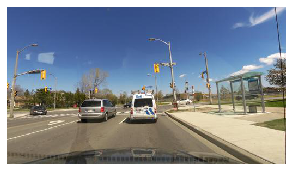

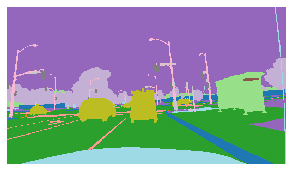

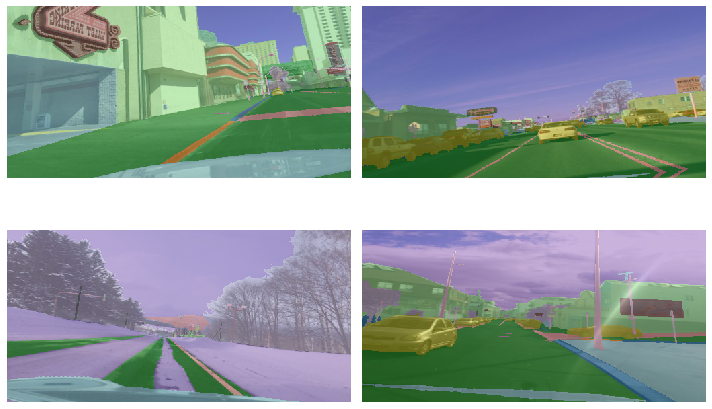

In [4]:
path_img = PosixPath('preprocessed_data/training/images/')
path_lbl = PosixPath('preprocessed_data/training/labels/')

valid_img = PosixPath('preprocessed_data/validation/images/')
valid_lbl = PosixPath('preprocessed_data/validation/labels/')

fnames = get_image_files(path_img)
fnames[:3]

lbl_names = get_image_files(path_lbl)
lbl_names[:3]


img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

def get_y_fn(x):
    return PosixPath(str(x).replace('images', 'class_labels', 1).replace('.jpg', '.png'))

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

# src_size changes depending on img
src_size = np.array(mask.shape[1:])


with open('config.json') as config_file:
    config = json.load(config_file)

labels = config['labels']

codes = []
for label in labels:
    codes.append(label['readable'])
codes_arr = np.array(codes, dtype='str')


def filter_out_labels(fname):
    path = Path(fname)
    return os.path.basename(path.parent) != "labels" and            os.path.basename(path.parent) != "class_labels"


src = (SegmentationItemList.from_folder('/home/ec2-user/SageMaker/preprocessed_data/')
                     .filter_by_func(filter_out_labels)
                     .split_by_folder(train='training',valid='validation')
                     .label_from_func(get_y_fn, classes=codes_arr))

bs=8
data = (src.transform(get_transforms(), size=(256, 512), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

data.show_batch(2, figsize=(10,7))


def iou(pred, target, n_classes=None):
    if n_classes is None:    
        assert len(pred.size()) == 4
        n_classes = pred.size()[1]

    ious = []
    pred = pred.argmax(dim=1).view(-1)
    target = target.view(-1)

    for cls in range(n_classes):  
        pred_inds = pred == cls
        target_inds = target == cls
        # Cast to long to prevent overflows
        intersection = (pred_inds[target_inds]).long().sum().data.cpu().item() 
        union = (pred_inds.long().sum().data.cpu().item() +
                 target_inds.long().sum().data.cpu().item() -
                 intersection)

        # do not include in evaluation if no gt
        if union != 0:
            ious.append(float(intersection) / float(max(union, 1)))

    return torch.Tensor(ious).mean()

def iou_mapillary(pred, targ, n_classes=len(codes_arr)):
    return iou(pred, targ, n_classes)

def acc_mapillary(pred, targ):
    targ = targ.squeeze(1)
    return (pred.argmax(dim=1)==targ).float().mean()

metrics=[acc_mapillary, iou_mapillary]

unet_resnet18_learn = unet_learner(data, models.resnet18, metrics=metrics, wd=1e-2)
unet_resnet18_learn

In [7]:
unet_resnet18_learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 256]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 256]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 256]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 128]        0          False     
______________________________________________________________________
Conv2d               [64, 64, 128]        36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 128]        128        True      
______________________________________________________________________
ReLU                 [64, 64, 128]        0          False     
__________________________________________________

In [13]:
models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  